<a href="https://colab.research.google.com/github/Yohanes213/Hamoye/blob/main/Daily%20demand%20forecasting%20orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error ,accuracy_score,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression , Lasso, Ridge, OrthogonalMatchingPursuitCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [ ]:
df = pd.read_csv('/content/Daily Demand Forecasting Orders (1).csv')

**EXPLORATORY DATA ANALYSIS**

In [ ]:
df.head()

,Unnamed: 0,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [ ]:
df.shape

(60, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Unnamed: 0                                                          60 non-null     int64  
 1   Week of the month (first week, second, third, fourth or fifth week  60 non-null     int64  
 2   Day of the week (Monday to Friday)                                  60 non-null     int64  
 3   Non-urgent order                                                    60 non-null     float64
 4   Urgent order                                                        60 non-null     float64
 5   Order type A                                                        60 non-null     float64
 6   Order type B                                                        60 non-null     float64
 7   Order type C       

In [ ]:
#check for missing values - NO MISSING VALUES
df.isnull().sum()

Unnamed: 0                                                            0
Week of the month (first week, second, third, fourth or fifth week    0
Day of the week (Monday to Friday)                                    0
Non-urgent order                                                      0
Urgent order                                                          0
Order type A                                                          0
Order type B                                                          0
Order type C                                                          0
Fiscal sector orders                                                  0
Orders from the traffic controller sector                             0
Banking orders (1)                                                    0
Banking orders (2)                                                    0
Banking orders (3)                                                    0
Target (Total orders)                                           

In [ ]:
#checks for duplicates- NO DUPLICATE VALUES
duplicates=df[df.duplicated()]
duplicates

,Unnamed: 0,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)


In [ ]:
#let check the basic statistics of the data= THERE IS TENDENCY OF OUTLIERS IN SOME OF THE COLUMNS
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,60.0,29.500000,17.464249,0.000,14.75000,29.5000,44.25000,59.000
"Week of the month (first week, second, third, fourth or fifth week",60.0,3.016667,1.282102,1.000,2.00000,3.0000,4.00000,5.000
Day of the week (Monday to Friday),60.0,4.033333,1.401775,2.000,3.00000,4.0000,5.00000,6.000
Non-urgent order,60.0,172.554933,69.505788,43.651,125.34800,151.0625,194.60650,435.304
Urgent order,60.0,118.920850,27.170929,77.371,100.88800,113.1145,132.10825,223.270
Order type A,60.0,52.112217,18.829911,21.826,39.45625,47.1665,58.46375,118.178
Order type B,60.0,109.229850,50.741388,25.125,74.91625,99.4820,132.17100,267.342
Order type C,60.0,139.531250,41.442932,74.372,113.63225,127.9900,160.10750,302.448
Fiscal sector orders,60.0,77.396133,186.502470,0.000,1.24325,7.8315,20.36075,865.000
Orders from the traffic controller sector,60.0,44504.350000,12197.905134,11992.000,34994.25000,44312.0000,52111.75000,71772.000


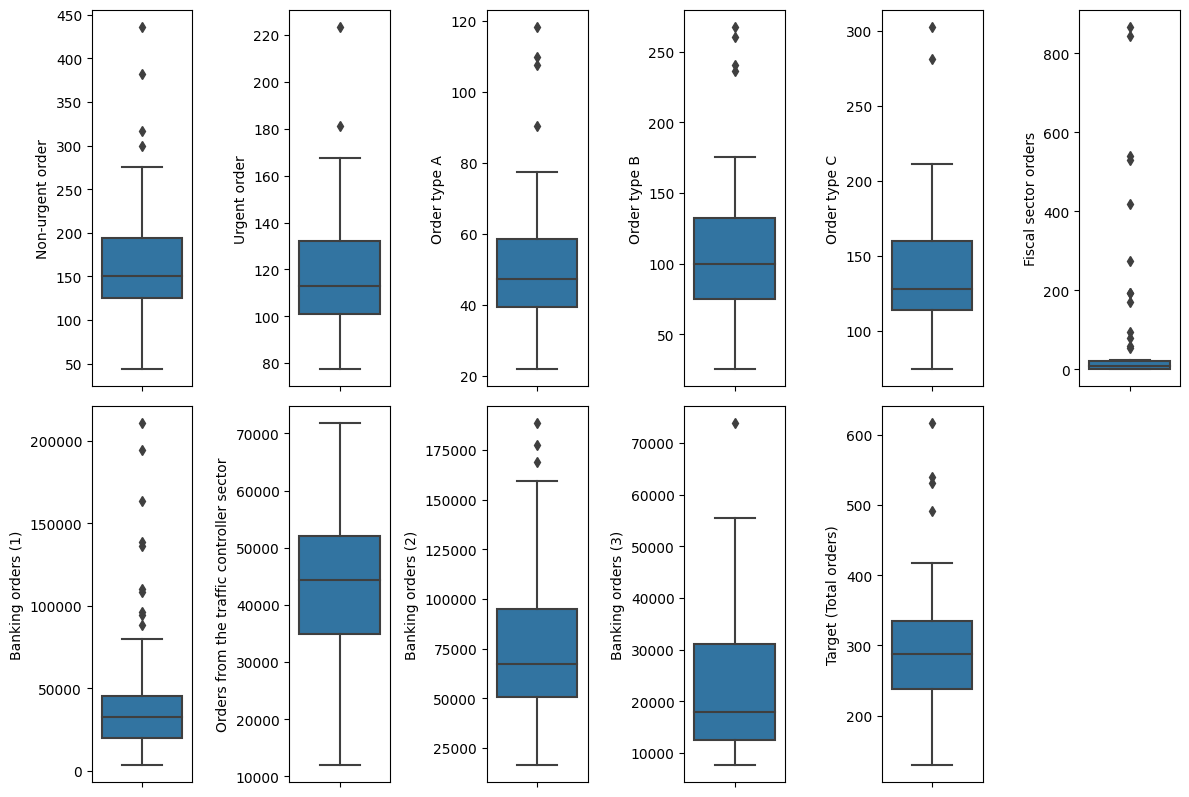

In [ ]:
#Lets check for outliers using boxplot = the output shows that the column for Fiscal sector orders
#and Banking orders (1) has outliers.
f, axes = plt.subplots(3, 6, figsize=(12, 12))

axes = axes.flatten()
columns = ['Non-urgent order', 'Urgent order', 'Order type A', 'Order type B', 'Order type C',
           'Fiscal sector orders', 'Banking orders (1)', 'Orders from the traffic controller sector',
           'Banking orders (2)', 'Banking orders (3)', 'Target (Total orders)']

for col, ax in zip(columns, axes):
    sns.boxplot(y=col, data=df, ax=ax)

for i in range(len(columns), len(axes)):
    f.delaxes(axes[i])

plt.tight_layout()

plt.show()

In [ ]:
#let check for data skewness =MOST OF THE DATA ARE POSIVITELY SKEW BUT ARE ALL WITH THE ACCEPTABLE RANGE
df.skew()

Unnamed: 0                                                            0.000000
Week of the month (first week, second, third, fourth or fifth week    0.017892
Day of the week (Monday to Friday)                                   -0.022888
Non-urgent order                                                      1.546244
Urgent order                                                          1.300066
Order type A                                                          1.724497
Order type B                                                          1.339496
Order type C                                                          1.728385
Fiscal sector orders                                                  3.146895
Orders from the traffic controller sector                             0.039353
Banking orders (1)                                                    2.043421
Banking orders (2)                                                    0.948538
Banking orders (3)                                  

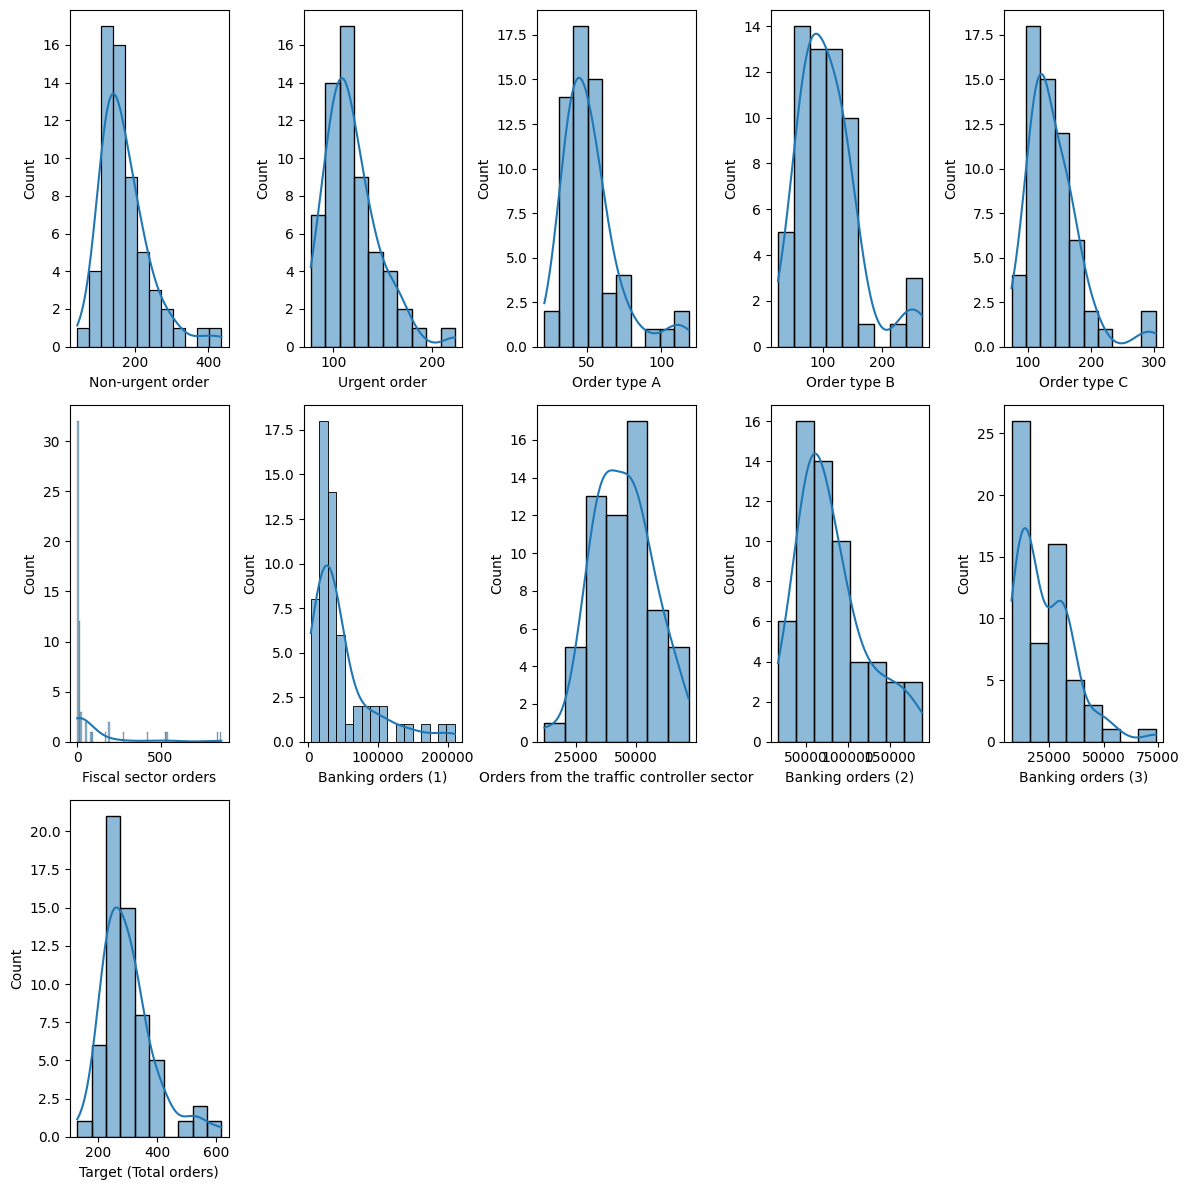

In [ ]:
#Lets check the distribution using histogram= as can be seen most data are skewed to the right with more bar in the
# right side of the mean, however, they are all almost normally distributed
f, axes = plt.subplots(3, 5, figsize=(12, 12))

axes = axes.flatten()

columns = ['Non-urgent order', 'Urgent order', 'Order type A', 'Order type B', 'Order type C',
           'Fiscal sector orders', 'Banking orders (1)', 'Orders from the traffic controller sector',
           'Banking orders (2)', 'Banking orders (3)', 'Target (Total orders)']

for col, ax in zip(columns, axes):
    sns.histplot(data=df, x=col, kde=True, ax=ax)

for i in range(len(columns), len(axes)):
    f.delaxes(axes[i])

plt.tight_layout()
plt.show()

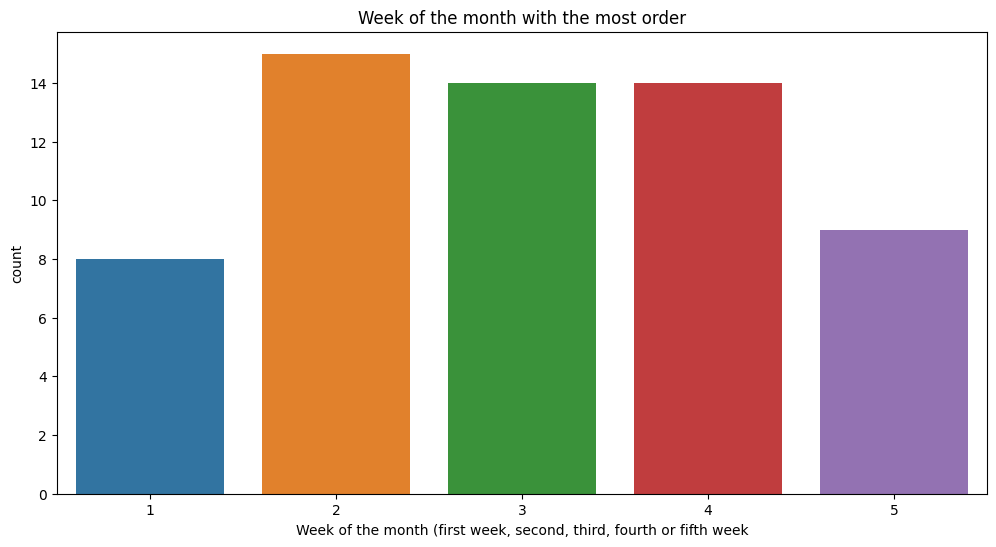

In [ ]:
#week order seem to be more in week 2 compare to other week, although week 3 and 4 are not far off.
#However, week 1 seem to have orders
plt.figure(figsize=(12,6))
sns.countplot(x='Week of the month (first week, second, third, fourth or fifth week', data=df)
plt.title('Week of the month with the most order');

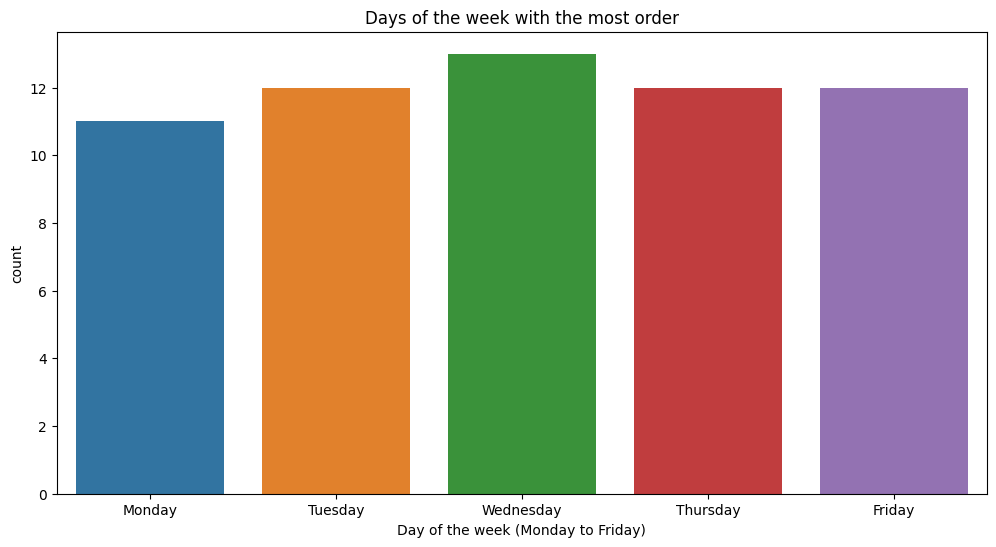

In [ ]:
# there seem not to be much difference in the order base on days of the week
#however, like the week of the month, order seem to start slow on the first day of the week and get to it peak by wednesday
#and then start decreasing from thursday again
plt.figure(figsize=(12,6))
fig=sns.countplot(x='Day of the week (Monday to Friday)', data=df)
fig.set(xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.title('Days of the week with the most order');

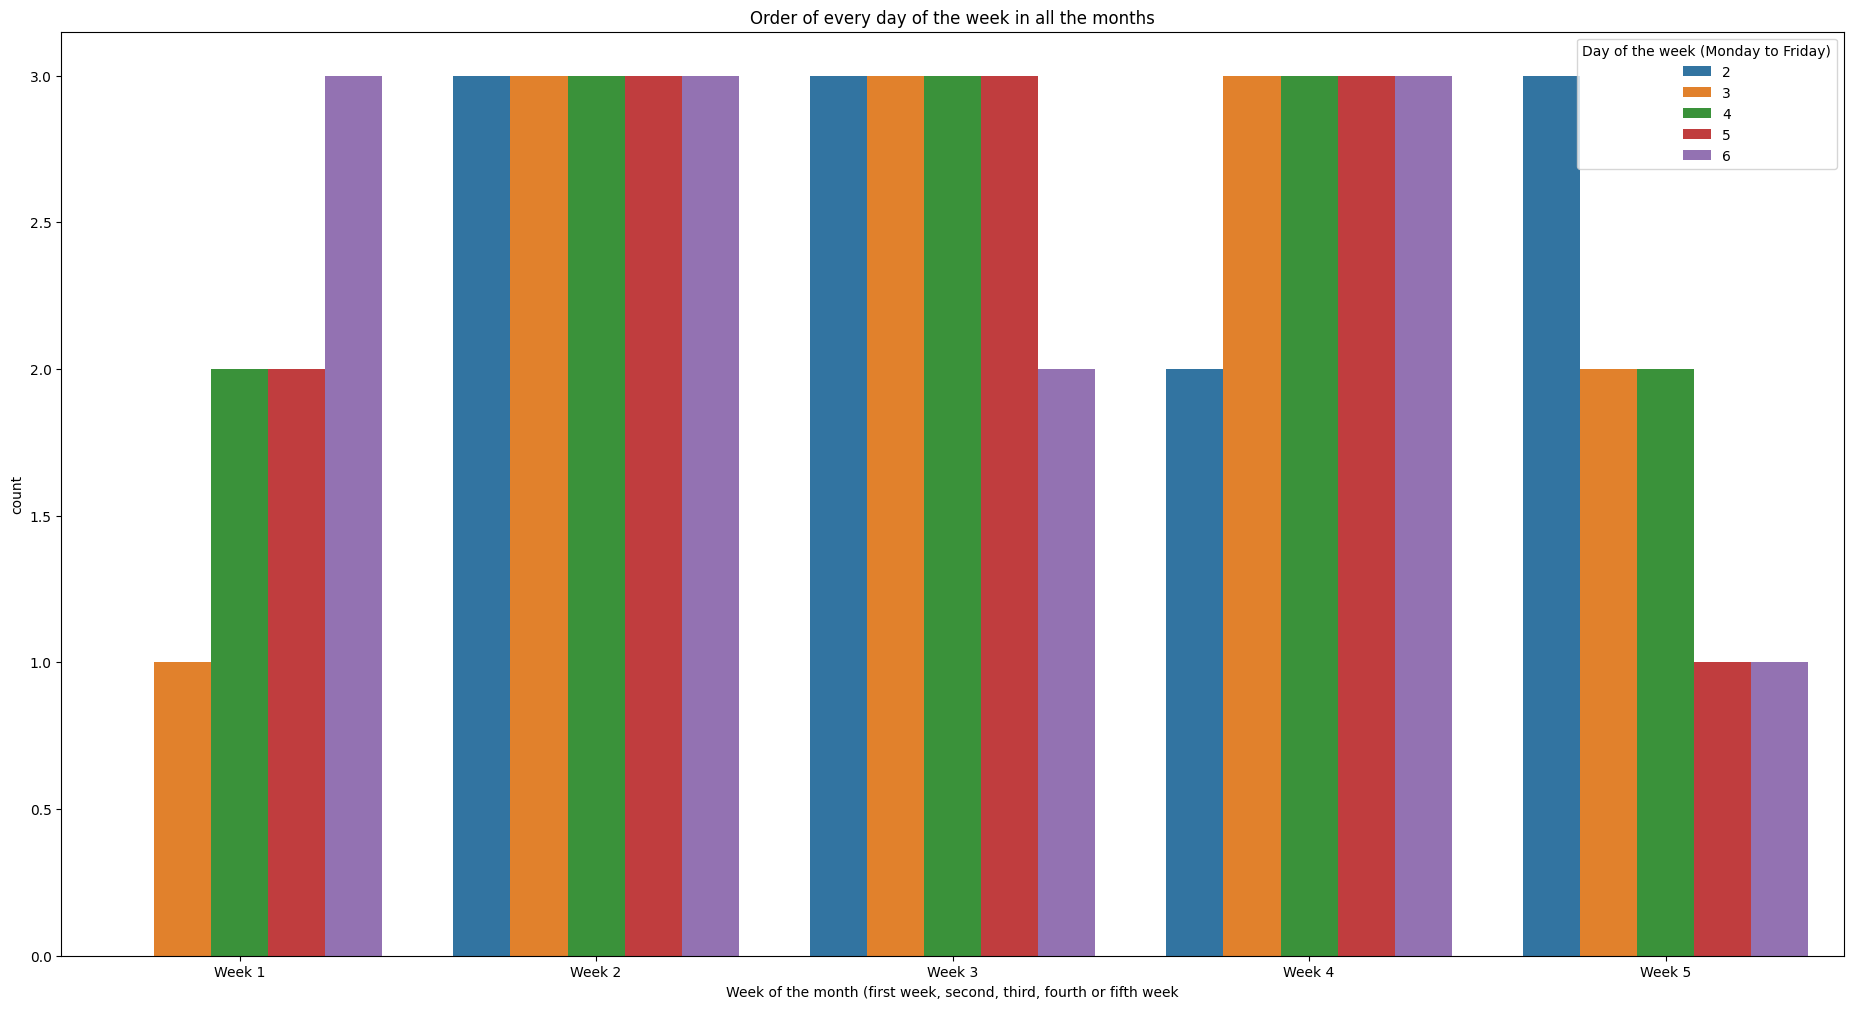

In [ ]:
#now if week break the order to day of the week in every month
#we found out that order begin to raise from friday of week 1 get to its peak in week 2,3 and 4 and start to
#falling from tuesday of week 5
plt.figure(figsize=(23,12))
fig =sns.countplot(x='Week of the month (first week, second, third, fourth or fifth week', hue='Day of the week (Monday to Friday)', data=df)
fig.set(xticklabels=['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5'])
#plt.legend(['Monday', 'Tuesday', 'Wednsday', 'Thurdsday', 'Friday'])
plt.title('Order of every day of the week in all the months');

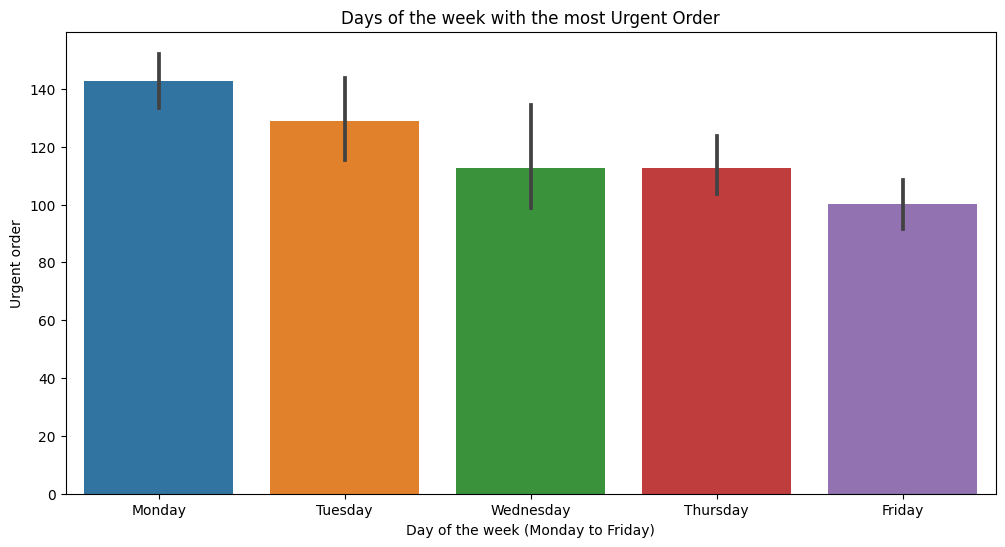

In [ ]:
#Interestly people seem to spend more on Urgent Order on Mondays and decrease slowly to Friday
plt.figure(figsize=(12,6))
fig =sns.barplot(x='Day of the week (Monday to Friday)', y='Urgent order', data=df)
fig.set(xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

plt.title('Days of the week with the most Urgent Order');

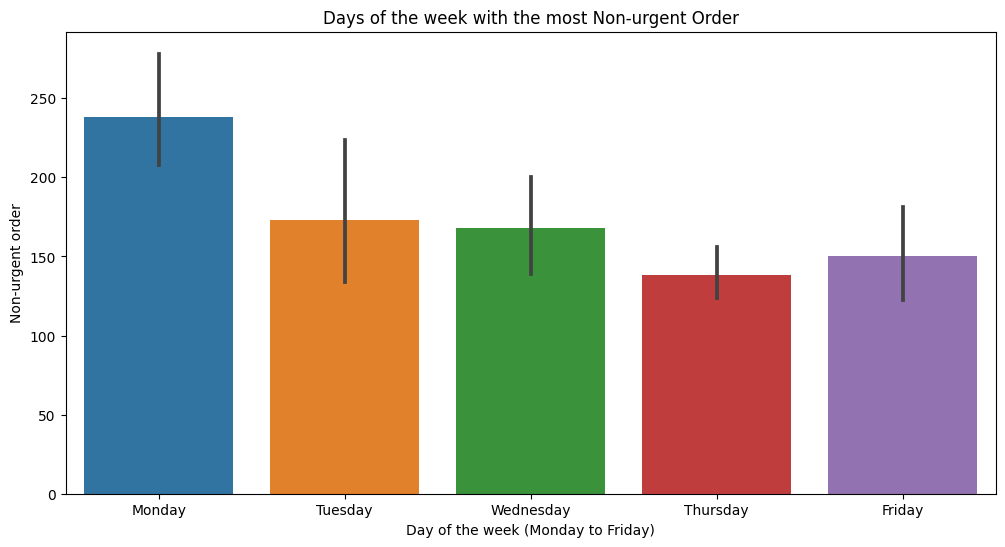

In [ ]:
#Again, like urgent order, people seem to spend more on Non-urgent on a monday and decrease down the week
plt.figure(figsize=(12,6))
fig =sns.barplot(x='Day of the week (Monday to Friday)', y='Non-urgent order', data=df)
fig.set(xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.title('Days of the week with the most Non-urgent Order');

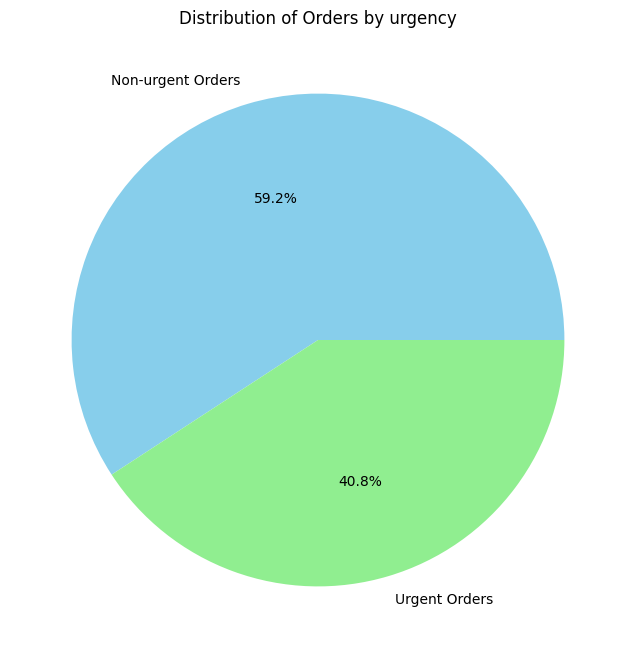

In [ ]:
#let check the order distribution by urgency= As expected Non-urgent orders are higher at 59.2#
#however, the percentage of urgent order are surprising high at 40+%=

labels = ['Non-urgent Orders', 'Urgent Orders']
data = [df['Non-urgent order' ].sum(), df['Urgent order'].sum()]

plt.figure(figsize=(12, 8))
plt.pie(data, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Distribution of Orders by urgency')

plt.show()

In [ ]:
#order type c is the most common type with 46.4%, follow by order type B, order type A has the lowest with
#just 17.3 %

labels = ['Order type A', 'Order type B', 'Order type C']
data = [df['Order type A'].sum(), df['Order type B'].sum(), df['Order type C'].sum()]

df_data = pd.DataFrame({'labels': labels, 'data': data})


fig = px.pie(df_data, values='data', names='labels', labels={'labels': 'Order Type'})


fig.update_layout(title='Distribution of Order Based on Types')


fig.show()

<Axes: >

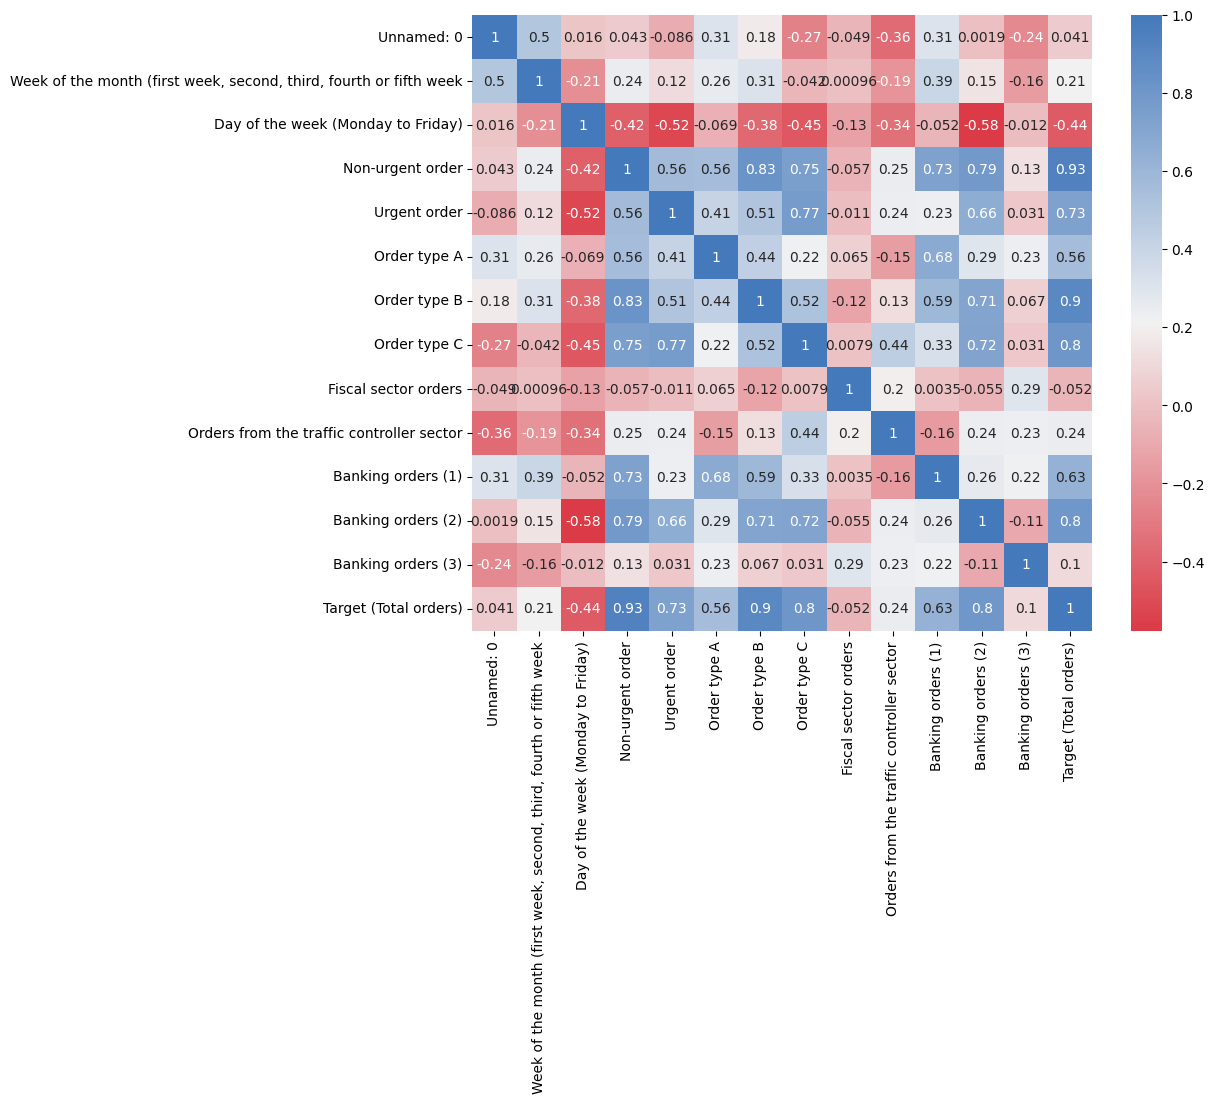

In [ ]:
plt.figure(figsize=(10,8))
corr = df.corr()
sns.heatmap(corr, annot = True, cmap=sns.diverging_palette(10, 250, as_cmap=True))

**DATA PREPARATION**

FEATURE SELECTION

In [ ]:
X_check = df.drop(columns=['Target (Total orders)'])
y_check = df['Target (Total orders)']

In [ ]:
scaler1 = StandardScaler()

X_scaled_check = scaler1.fit_transform(X_check)

In [ ]:
dt_model = DecisionTreeRegressor()

dt_model.fit(X_scaled_check, y_check)

DecisionTreeRegressor()

In [ ]:
print("The r2_score of the model is: ", r2_score(dt_model.predict(X_scaled_check), y_check))

The r2_score of the model is:  1.0


In [ ]:
print("The model score is: ",dt_model.score(X_scaled_check, y_check))

The model score is:  1.0


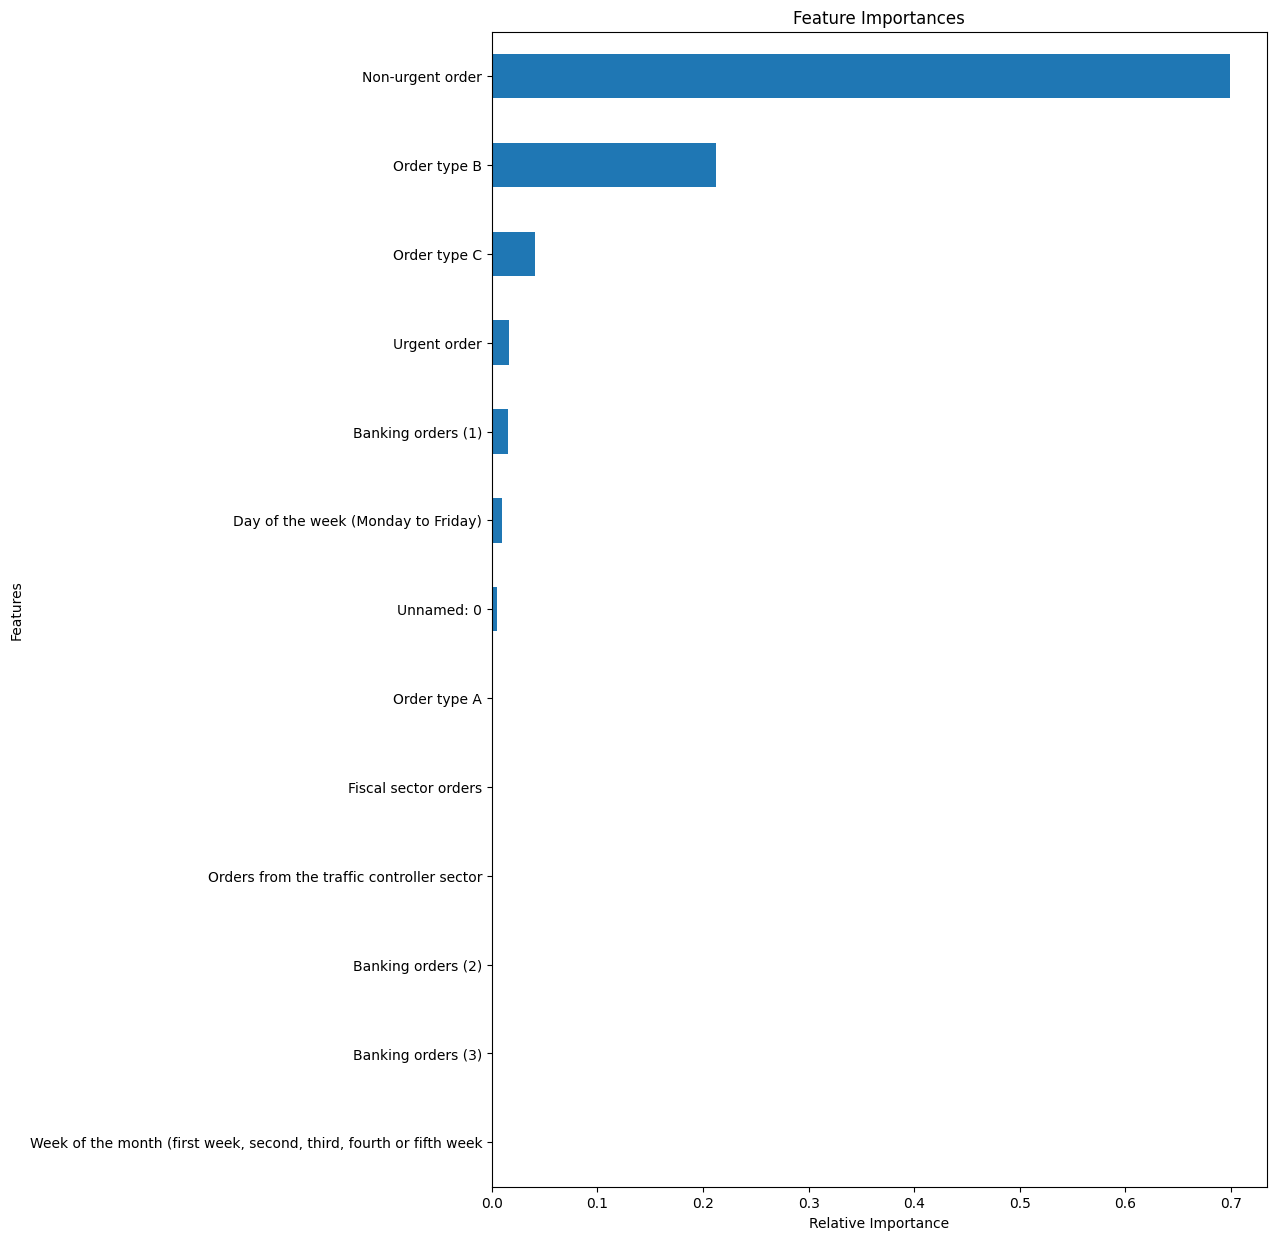

In [ ]:
plt.figure(figsize=(10,15))
plt.title('Feature Importances')
feat_importances = pd.Series(dt_model.feature_importances_, index=X_check.columns)
feat_importances.sort_values().plot(kind='barh')

plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
df_new = df.drop(columns=['Unnamed: 0',
                          'Week of the month (first week, second, third, fourth or fifth week',
                          'Banking orders (2)',
                          'Banking orders (1)',
                          'Orders from the traffic controller sector',
                          'Fiscal sector orders',
                          'Order type A'])

In [ ]:
df_new.columns

Index(['Day of the week (Monday to Friday)', 'Non-urgent order',
       'Urgent order', 'Order type B', 'Order type C', 'Banking orders (3)',
       'Target (Total orders)'],
      dtype='object')

In [ ]:
X = df_new.drop(columns=['Target (Total orders)'])
y = df_new['Target (Total orders)']

TRAIN TEST SPLIT FOR MODEL VALIDATION

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
scaler.fit(X)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
print("The r2_score of Training set is: ", r2_score(lr_model.predict(X_train_scaled), y_train))

The r2_score of Training set is:  0.9906727198780121


In [ ]:
print("The r2_score of Test set is: ", r2_score(lr_model.predict(X_test_scaled), y_test))

The r2_score of Test set is:  0.9268815767946438


In [ ]:
print("The model score for Test set is: ",  lr_model.score(X_test_scaled, y_test))

The model score for Test set is:  0.9277808811369413


**EVALUATION OF DIFFERENT REGRESSION MODELS**

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'XGBoost Regressor': XGBRegressor(),
    'DecisionTree Regressor': DecisionTreeRegressor(),
    'Catboost': CatBoostRegressor(),
    'KNeighborRegressor': KNeighborsRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'OrthogonalMatchingPursuitCV': OrthogonalMatchingPursuitCV(),
    'RandomForestRegressor': RandomForestRegressor()

}

In [ ]:
def fit_and_score(models, X_train, X_test, y_train, y_test):
  np.random.seed(42)

  model_test_scores={}
  model_train_scores={}
  r2_train_scores={}
  r2_test_scores={}
  mse_train_scores={}
  mse_test_scores={}

  for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    model_test_scores[name]= model.score(X_test, y_test)
    model_train_scores[name]= model.score(X_train, y_train)

    r2_test_scores[name]= r2_score(y_pred, y_test)
    r2_train_scores[name]= r2_score(y_pred_train, y_train)

    mse_test_scores[name]= mean_squared_error(y_pred, y_test)
    mse_train_scores[name]= mean_squared_error(y_pred_train, y_train)

  return (model_test_scores,
         model_train_scores,
         r2_test_scores,
         r2_train_scores,
         mse_test_scores,
         mse_train_scores)

In [ ]:
(test_score,
 train_score,
 r2_test,
 r2_train,
 mse_test,
 mse_train) = fit_and_score(models, X_train_scaled, X_test_scaled, y_train, y_test)

Learning rate set to 0.025341
0:	learn: 80.5344503	total: 47.2ms	remaining: 47.1s
1:	learn: 79.7353185	total: 48ms	remaining: 23.9s
2:	learn: 78.7945597	total: 48.6ms	remaining: 16.2s
3:	learn: 78.0394671	total: 49ms	remaining: 12.2s
4:	learn: 77.1241036	total: 49.6ms	remaining: 9.87s
5:	learn: 76.3118347	total: 51.1ms	remaining: 8.46s
6:	learn: 75.5286814	total: 51.7ms	remaining: 7.33s
7:	learn: 74.7532233	total: 52.4ms	remaining: 6.5s
8:	learn: 73.7365976	total: 53ms	remaining: 5.83s
9:	learn: 72.8002602	total: 53.5ms	remaining: 5.3s
10:	learn: 71.9520539	total: 56.2ms	remaining: 5.05s
11:	learn: 70.9964371	total: 56.7ms	remaining: 4.66s
12:	learn: 70.2393333	total: 57.3ms	remaining: 4.35s
13:	learn: 69.3697711	total: 57.9ms	remaining: 4.08s
14:	learn: 68.5996452	total: 58.5ms	remaining: 3.84s
15:	learn: 67.8921456	total: 59.1ms	remaining: 3.63s
16:	learn: 67.2066771	total: 60.6ms	remaining: 3.5s
17:	learn: 66.4641667	total: 61.2ms	remaining: 3.34s
18:	learn: 65.6053612	total: 61.7ms

In [ ]:
score = pd.DataFrame({
    "Test Score": test_score,
    "Test r2": r2_test,
    "Test mse": mse_test,
    "Train Score": train_score,
    "Train r2": r2_train,
    "Train mse": mse_train,

}, index=train_score.keys())

In [ ]:
score.sort_values(by='Test r2')

,Test Score,Test r2,Test mse,Train Score,Train r2,Train mse
RandomForestRegressor,0.700502,0.387304,3065.484110,0.980575,0.976337,1.285898e+02
DecisionTree Regressor,0.236381,0.499505,7815.939649,1.000000,1.000000,0.000000e+00
Catboost,0.765268,0.542927,2402.576502,0.999968,0.999968,2.103728e-01
KNeighborRegressor,0.761277,0.573622,2443.422835,0.826748,0.632260,1.146869e+03
GradientBoosting,0.800971,0.696025,2037.143028,0.999986,0.999986,9.514906e-02
XGBoost Regressor,0.654837,0.710349,3532.875659,1.000000,1.000000,6.531043e-07
Lasso,0.910188,0.905533,919.262731,0.989674,0.989238,6.835310e+01
OrthogonalMatchingPursuitCV,0.927158,0.926127,745.563555,0.990706,0.990618,6.152543e+01
Linear Regression,0.927781,0.926882,739.191046,0.990759,0.990673,6.117279e+01
Ridge,0.948331,0.945754,528.852101,0.990234,0.989945,6.464664e+01


**Dimensionality reduction**

In [ ]:
#using pca
pca = PCA(n_components = 5)

In [ ]:
#COPYING THE DATASET
X_train_scaled1 = X_train_scaled.copy()
X_train_scaled1 = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_train_scaled1.head()

,Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type B,Order type C,Banking orders (3)
0,0.695422,-0.024475,0.465497,0.224938,0.437359,1.025338
1,-1.462783,-0.018251,0.324610,0.080771,0.553647,-0.359843
2,-0.023980,-1.103546,-1.173819,-0.549595,-1.585533,-0.592470
3,1.414823,-0.974113,-0.379788,-0.750363,-0.622839,-0.422966
4,-1.462783,0.671769,0.202651,0.775967,0.547807,-0.970749


In [ ]:
#COPYING THE DATASET
X_test_scaled1 = X_test_scaled.copy()
X_test_scaled1 = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_test_scaled1.head()

,Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type B,Order type C,Banking orders (3)
0,-0.023980,2.085656,3.872880,1.318768,3.964285,-0.638259
1,-0.023980,-0.894171,-0.837338,-1.163148,-0.332471,0.141998
2,-1.462783,3.035411,0.783867,3.008980,0.306665,1.878075
3,-1.462783,0.221331,1.801327,0.414736,0.698916,-0.971899
4,-1.462783,0.693343,0.834528,0.231238,1.381268,0.465820


In [ ]:
#using pca
X_train_pca = pca.fit_transform(X_train_scaled1)
X_test_pca = pca.transform(X_test_scaled1)

In [ ]:
(test_score1,
 train_score1,
 r2_test1,
 r2_train1,
 mse_test1,
 mse_train1) = fit_and_score(models, X_train_pca, X_test_pca, y_train, y_test)

Learning rate set to 0.025341
0:	learn: 80.6081663	total: 25.5ms	remaining: 25.5s
1:	learn: 80.1728271	total: 26.7ms	remaining: 13.3s
2:	learn: 79.5775387	total: 27.9ms	remaining: 9.26s
3:	learn: 78.8416390	total: 29ms	remaining: 7.22s
4:	learn: 78.1360119	total: 30.2ms	remaining: 6s
5:	learn: 77.5448796	total: 31.3ms	remaining: 5.18s
6:	learn: 76.6723401	total: 32.6ms	remaining: 4.62s
7:	learn: 76.0715238	total: 33.8ms	remaining: 4.2s
8:	learn: 75.2664464	total: 35.1ms	remaining: 3.86s
9:	learn: 74.6460909	total: 36.3ms	remaining: 3.59s
10:	learn: 73.9998408	total: 37.5ms	remaining: 3.37s
11:	learn: 73.4028693	total: 38.8ms	remaining: 3.19s
12:	learn: 72.8912771	total: 40ms	remaining: 3.03s
13:	learn: 72.2668218	total: 41.2ms	remaining: 2.9s
14:	learn: 71.6304211	total: 42.7ms	remaining: 2.81s
15:	learn: 70.8722939	total: 43ms	remaining: 2.64s
16:	learn: 70.2002173	total: 43.3ms	remaining: 2.5s
17:	learn: 69.6628148	total: 43.9ms	remaining: 2.4s
18:	learn: 68.9806584	total: 44.5ms	rem

In [ ]:
score_pca = pd.DataFrame({
    "Test Score": test_score1,
    "Test r2": r2_test1,
    "Test mse": mse_test1,
    "Train Score": train_score1,
    "Train r2": r2_train1,
    "Train mse": mse_train1,

}, index=train_score1.keys())

In [ ]:
score_pca.sort_values(by='Test r2')

,Test Score,Test r2,Test mse,Train Score,Train r2,Train mse
Catboost,0.707000,0.155951,2998.968340,0.999989,0.999989,7.092091e-02
KNeighborRegressor,0.786566,0.602503,2184.576345,0.826985,0.633608,1.145300e+03
DecisionTree Regressor,0.629346,0.694607,3793.790799,1.000000,1.000000,0.000000e+00
RandomForestRegressor,0.856491,0.797377,1468.873144,0.965645,0.956310,2.274198e+02
XGBoost Regressor,0.919257,0.914228,826.432714,1.000000,1.000000,5.981038e-07
GradientBoosting,0.935316,0.926851,662.061642,0.999955,0.999955,2.946856e-01
Lasso,0.967548,0.964405,332.160607,0.987255,0.986782,8.436516e+01
Ridge,0.969999,0.968062,307.073957,0.988488,0.988139,7.620372e+01
Linear Regression,0.971611,0.970388,290.575555,0.988623,0.988492,7.531370e+01
OrthogonalMatchingPursuitCV,0.971611,0.970388,290.575555,0.988623,0.988492,7.531370e+01


In [ ]:
om = OrthogonalMatchingPursuitCV()
om.fit(X_train_pca, y_train)

OrthogonalMatchingPursuitCV()

In [ ]:
print("The r2_score of Training set is: ", r2_score(om.predict(X_train_pca), y_train))

The r2_score of Training set is:  0.9884917800730987


In [ ]:
print("The r2_score of Training set is: ", r2_score(om.predict(X_test_pca), y_test))

The r2_score of Training set is:  0.9703879616129775


In [ ]:
print("The model score for Test set is: ", (om.score(X_test_pca, y_test)))

The model score for Test set is:  0.9716107079004515


In [ ]:
y_pred = om.predict(X_test_pca)

In [ ]:
prediction = pd.DataFrame({
    "True Value": y_test,
    "Predicted Value": y_pred,
    "Residual": y_test-y_pred
})

In [ ]:
prediction

,True Value,Predicted Value,Residual
0,539.577,562.406723,-22.829723
1,207.364,210.777329,-3.413329
2,530.944,513.434218,17.509782
3,357.394,359.896923,-2.502923
4,363.402,365.553325,-2.151325
5,213.509,221.371605,-7.862605
6,346.035,346.476797,-0.441797
7,402.607,353.789106,48.817894
8,308.178,318.354786,-10.176786
9,303.447,307.969254,-4.522254


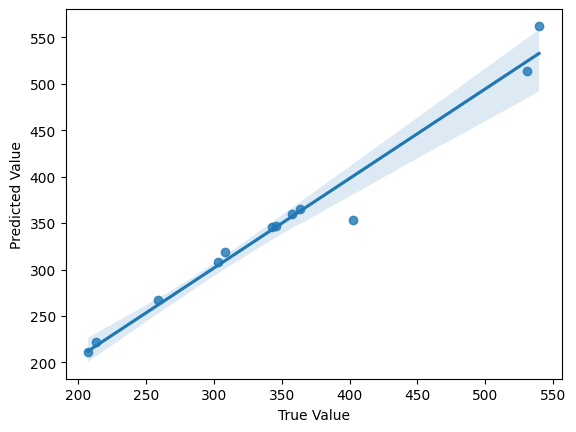

In [ ]:
sns.regplot(x= 'True Value', y='Predicted Value', data=prediction);

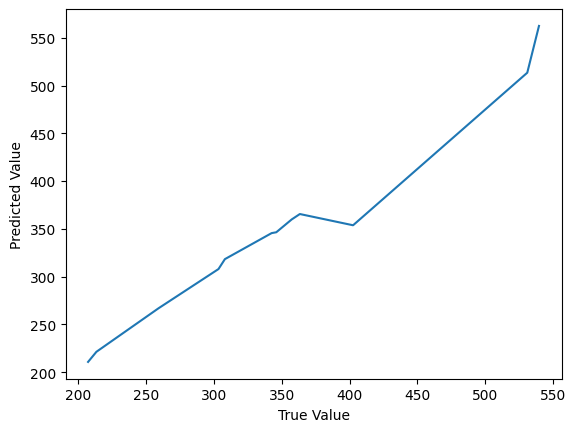

In [ ]:
sns.lineplot(x= 'True Value', y='Predicted Value', data=prediction);

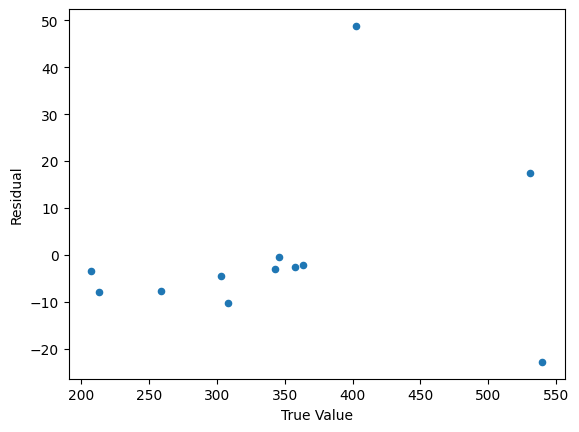

In [ ]:
#plotting the true value against the residual

scatter = prediction.plot(kind='scatter', x="True Value", y='Residual')

<Axes: xlabel='Predicted Value', ylabel='Residual'>

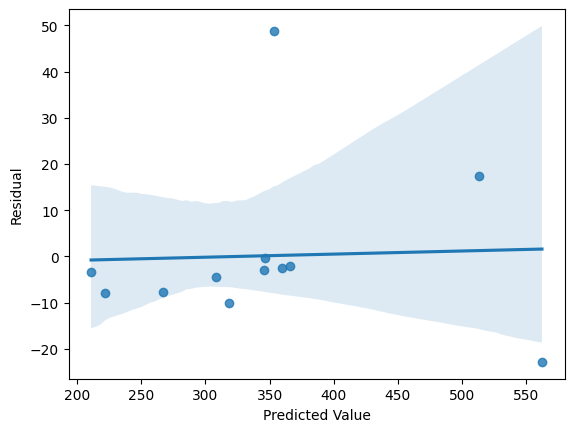

In [ ]:
sns.regplot( x='Predicted Value',y= 'Residual', data=prediction)

<Axes: xlabel='Residual', ylabel='Count'>

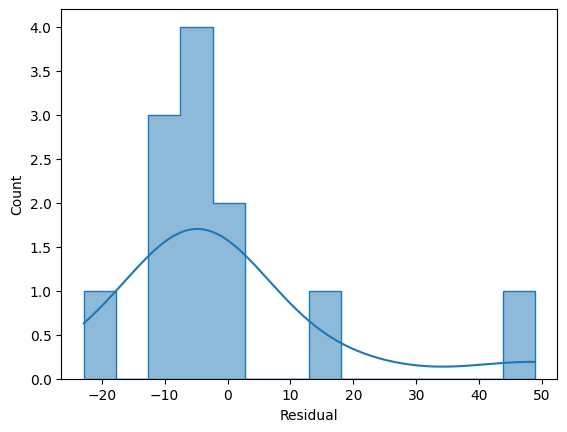

In [ ]:
sns.histplot(prediction['Residual'], kde=True, element='step')